Putting the sequential feeding of data into the RNN part of the RNN module (how else are we going to be able to train our thalamus layer??). Implements strucutre of RNN then linear layer then RNN. DOES NOT RUN BUT I AM TIRED AND AM GIVING UP

In [2]:
from scipy.io import loadmat
import numpy as np
import torch 


In [3]:
monkey_data = loadmat('monkey_data.mat') 
visual_data = monkey_data['inp'][0]
muscle_data = monkey_data['targ'][0]

In [4]:
test = np.zeros((502, 2))
for i, data in enumerate(visual_data):
    test[i] = data.shape

print(test[:,1].max())

341.0


In [5]:
batch_size = visual_data.shape[0] # N, 502
trial_len = int(test[:,1].max()) # visual_data[0].shape[1] # T, 298 
in_dim = visual_data[0].shape[0] # L, 21
out_dim = muscle_data[0].shape[0] # O, 50

hid_dim = 100
num_layers = 3

In [6]:
new_visual_data = np.zeros((batch_size, trial_len, in_dim))

for i, data in enumerate(visual_data):
    new_visual_data[i, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
print(new_visual_data.shape)

(502, 341, 21)


In [70]:
import math
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
# np.random.seed()

 # shuffling was somehow change 
train_idx, test_idx = train_test_split(
     range(batch_size), 
     test_size=0.2, 
     shuffle=True )

train_input = np.zeros((int(batch_size * .8), trial_len, in_dim))
train_output = np.zeros((int(batch_size * .8), trial_len, out_dim))
test_input = np.zeros((int(np.ceil(batch_size * .2)), trial_len, in_dim))
test_output = np.zeros((int(np.ceil(batch_size * .2)), trial_len, out_dim))
train_ind = 0
test_ind = 0
for i, data in enumerate(visual_data):
     if i in train_idx:
       # train_input[train_ind, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
       train_input[train_ind, -visual_data[i].shape[1]:, :] = visual_data[i].transpose()
       train_output[train_ind, -visual_data[i].shape[1]:, :] = muscle_data[i].transpose()
       train_ind += 1
     else:
        test_input[test_ind, -visual_data[i].shape[1]:, :] = visual_data[i].transpose()
        test_output[test_ind, -visual_data[i].shape[1]:, :] = muscle_data[i].transpose()
        test_ind += 1

# for use in weighted loss
muscle_length_vec = torch.tensor([9.8, 10.8, 13.7, 6.8, 7.6, 8.7, 7.4, 16.2, 14.4, 13.8, 13.8, 25.4, 23.2, 27.9, 9.3, 13.4, 11.4, 11.4, 2.7, 3.3, 11.6, 13.2, 8.6, 17.3, 8.1, 5.9, 6.2, 6.3, 5.1, 6.4, 4.9, 2.8, 5.2, 7.4, 7.5, 8.4, 7.5, 8.0, 8.4, 7.5, 6.5, 6.3, 7.2, 7.0, 6.8, 5.9, 5.4, 6.8, 5.5, 7.1])
muscle_weight_vec = (1/muscle_length_vec) * (2.5*torch.min(muscle_length_vec))





- ReTanh activation function --> yes
- rate regularization: 1e-1 --> yes
- weight regularization: 1e-5 --> yes
- intermodule sparsity: 0.1 --> yes
- Hessian free optimization --> yes
- birdirectional --> no

In [32]:
def hardcore_loss(output, target, model_params):
    firing_reg = 1e-1
    weight_reg = 1e-5
    weight_sum = torch.zeros((1))
    for name, param in model_params: 
        if "weight" in name:
            weight_sum += torch.sum(param **  2)

    loss = torch.sum((output - target)**2) + firing_reg * torch.sum(output ** 2) + weight_reg * weight_sum
    return loss

In [69]:
def hardcore_loss_weighted(output, target, model_params):
    firing_reg = 1e-1
    weight_reg = 1e-5
    weight_sum = torch.zeros((1))
    for name, param in model_params: 
        if "weight" in name:
            weight_sum += torch.sum(param **  2)
    
    # not entirely sure if this line is right
    
    target_diff_sum = torch.sum((muscle_weight_vec*(output - target))**2)

    loss = target_diff_sum + firing_reg * torch.sum(output ** 2) + weight_reg * weight_sum
    return loss

In [67]:
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

from mrnn import MilliesRNN
from hessianfree import HessianFree

learning_rate = 0.001
hessian = False
hardcore = True
intermodule_connections_removed = .9


model = MilliesRNN(in_dim, hid_dim, out_dim, True)
module1 = model.h2o
prune.random_unstructured(module1, name="weight", amount=intermodule_connections_removed)
module2 = model.thal
prune.random_unstructured(module2, name="weight", amount=intermodule_connections_removed)
model.train()
batches = []
shuffed = np.arange(0,401)
np.random.shuffle(shuffed)
for i in range(5):
    idx = shuffed[int((train_input.shape[0]/5)*i):int((train_input.shape[0]/5)*(i+1))]
    batches.append(idx)
outputs = model(torch.from_numpy(train_input[batches[0]]).to(torch.float32))   
loss = hardcore_loss(outputs, torch.from_numpy(train_output[batches[0]]).to(torch.float32), model.named_parameters())
print(loss)

loss_weighted = hardcore_loss_weighted(outputs, torch.from_numpy(train_output[batches[0]]).to(torch.float32), model.named_parameters())
print(loss_weighted)


tensor([33737.1094], grad_fn=<AddBackward0>)
tensor([0.6888, 0.6250, 0.4927, 0.9926, 0.8882, 0.7759, 0.9122, 0.4167, 0.4688,
        0.4891, 0.4891, 0.2657, 0.2909, 0.2419, 0.7258, 0.5037, 0.5921, 0.5921,
        2.5000, 2.0455, 0.5819, 0.5114, 0.7849, 0.3902, 0.8333, 1.1441, 1.0887,
        1.0714, 1.3235, 1.0547, 1.3776, 2.4107, 1.2981, 0.9122, 0.9000, 0.8036,
        0.9000, 0.8438, 0.8036, 0.9000, 1.0385, 1.0714, 0.9375, 0.9643, 0.9926,
        1.1441, 1.2500, 0.9926, 1.2273, 0.9507])
tensor([27365.6621], grad_fn=<AddBackward0>)


In [68]:
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

from mrnn import MilliesRNN
from hessianfree import HessianFree

learning_rate = 0.001
hessian = False
hardcore = True
intermodule_connections_removed = .9


model = MilliesRNN(in_dim, hid_dim, out_dim, True)
module1 = model.h2o
prune.random_unstructured(module1, name="weight", amount=intermodule_connections_removed)
module2 = model.thal
prune.random_unstructured(module2, name="weight", amount=intermodule_connections_removed)

if hardcore:
    criterion1 = hardcore_loss
    criterion2 = hardcore_loss_weighted
else:
    criterion1 = nn.MSELoss() 

if hessian:
    optimizer = HessianFree(model.parameters(), use_gnm=True, verbose=True)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 20
print_interval = 100
loss_error = []

preds = np.zeros((int(batch_size * .8), trial_len, out_dim))

model.train()
for epoch in range(num_epochs):
    batches = []
    shuffed = np.arange(0,401)
    np.random.shuffle(shuffed)
    for i in range(5):
        idx = shuffed[int((train_input.shape[0]/5)*i):int((train_input.shape[0]/5)*(i+1))]
        
        batches.append(idx)
    
    for j, batch in enumerate(batches):
        
        optimizer.zero_grad()

        outputs = model(torch.from_numpy(train_input[batch]).to(torch.float32))   

        if hardcore:
            if epoch < num_epochs/2:
                loss = criterion1(outputs, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
            else:
                print("crit 2")
                loss = criterion2(outputs, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
        else:
            loss = criterion1(outputs, torch.from_numpy(train_output[batch]).to(torch.float32))
        
            
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        def closure():
            gen_output = model(torch.from_numpy(train_input[batch]).to(torch.float32))
            loss = criterion1(gen_output, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
            loss.backward(create_graph=True)
            return loss, gen_output
        
        if hessian:
            optimizer.step(closure, M_inv=None)
        else: # gradient descent
            loss.backward()
            optimizer.step()

        loss_error.append(loss.item())
        # if i == 0 or (i + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Step [{j + 1}/{len(train_output)}], "
            f"Loss: {loss.item():.4f}"
        )
        



Epoch [1/20], Step [1/401], Loss: 34152.1328
Epoch [1/20], Step [2/401], Loss: 32948.2461
Epoch [1/20], Step [3/401], Loss: 29806.5488
Epoch [1/20], Step [4/401], Loss: 28768.8496
Epoch [1/20], Step [5/401], Loss: 27800.3535
Epoch [2/20], Step [1/401], Loss: 27919.1699
Epoch [2/20], Step [2/401], Loss: 25826.9102
Epoch [2/20], Step [3/401], Loss: 26873.6680
Epoch [2/20], Step [4/401], Loss: 26282.9004
Epoch [2/20], Step [5/401], Loss: 25808.7285
Epoch [3/20], Step [1/401], Loss: 25751.3711
Epoch [3/20], Step [2/401], Loss: 26235.7207
Epoch [3/20], Step [3/401], Loss: 26193.3086
Epoch [3/20], Step [4/401], Loss: 26450.7129
Epoch [3/20], Step [5/401], Loss: 25147.6172
Epoch [4/20], Step [1/401], Loss: 26009.0098
Epoch [4/20], Step [2/401], Loss: 26549.3203
Epoch [4/20], Step [3/401], Loss: 25571.5156
Epoch [4/20], Step [4/401], Loss: 24956.0723
Epoch [4/20], Step [5/401], Loss: 25755.2715
Epoch [5/20], Step [1/401], Loss: 25144.1875
Epoch [5/20], Step [2/401], Loss: 25683.6328
Epoch [5/2

Text(0, 0.5, 'loss')

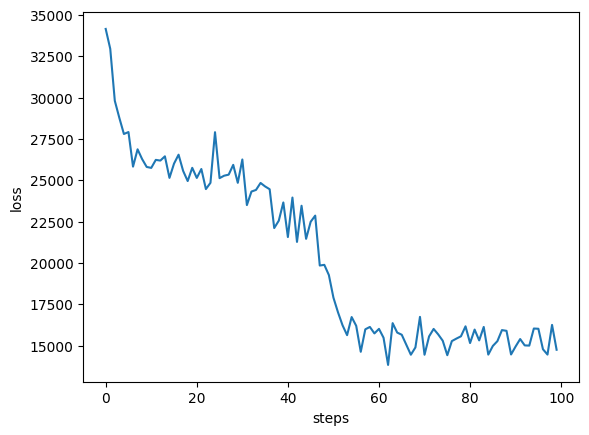

In [71]:
import matplotlib.pyplot as plt

plt.plot(loss_error)
plt.xlabel("steps")
plt.ylabel("loss")

In [57]:
n=3
plt.plot(np.average(np.array(loss_error).reshape(-1, n), axis=1))
plt.xlabel("steps")
plt.ylabel("mse loss")

ValueError: cannot reshape array of size 100 into shape (3)

In [58]:
preds = torch.empty(batch_size, trial_len, out_dim)

num_correct = 0
num_samples = len(test_dataset)

model.eval()


total_loss = 0
with torch.no_grad():
    for (input, output) in test_dataset:
        out, hidden_state = model(input)
        loss = criterion(out, output)
        total_loss += loss

print(f"Average test loss: {total_loss / 101}")

NameError: name 'test_dataset' is not defined

In [ ]:
    """for i, (input, output) in enumerate(train_dataset): # 80% of 502 different examples

        gen_output, hn = model(input)        

        loss = criterion(gen_output, output)
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        def closure():
            gen_output, _ = model(input)
            loss = criterion(gen_output, output)
            loss.backward(create_graph=True)
            return loss, gen_output
        optimizer.step(closure, M_inv=None)
        # add regularization loss with rate and weights here??
        # rate by taking L2 with matrix of zeroes
        loss_error.append(loss.item())
        
        if i == 0 or (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )"""

In [ ]:
model2 = MilliesRNN(in_dim, hid_dim, out_dim)

module = model2.